In [10]:
"""
The MIT License (MIT)
Copyright (c) 2021 NVIDIA
Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""


'\nThe MIT License (MIT)\nCopyright (c) 2021 NVIDIA\nPermission is hereby granted, free of charge, to any person obtaining a copy of\nthis software and associated documentation files (the "Software"), to deal in\nthe Software without restriction, including without limitation the rights to\nuse, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of\nthe Software, and to permit persons to whom the Software is furnished to do so,\nsubject to the following conditions:\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS\nFOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR\nCOPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER\nIN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OU

This code example demonstrates how to use a convolutional neural network to solve an image classification problem, using the CIFAR-10 dataset. More context for this code example can be found in the section "Programming Example: Image Classification with a Convolutional Network" in Chapter 7 in the book Learning Deep Learning by Magnus Ekman (ISBN: 9780137470358).


The first code snippet shows the initialization code for our CNN program. Among the import statements, we now import a new layer called Conv2D, which is a 2D convolutional layer. We load and standardize the CIFAR-10 dataset.

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
import numpy as np
import logging
tf.get_logger().setLevel(logging.ERROR)

EPOCHS = 128
BATCH_SIZE = 32

# Load dataset.
cifar_dataset = keras.datasets.cifar10
(train_images, train_labels), (test_images,
    test_labels) = cifar_dataset.load_data()

# Standardize dataset.
mean = np.mean(train_images)
stddev = np.std(train_images)
train_images = (train_images - mean) / stddev
test_images = (test_images - mean) / stddev
print('mean: ', mean)
print('stddev: ', stddev)

# Change labels to one-hot.
train_labels = to_categorical(train_labels,
                              num_classes=10)
test_labels = to_categorical(test_labels,
                             num_classes=10)


mean:  120.70756512369792
stddev:  64.1500758911213


The actual model is created by the next code snippet, which first declares a Sequential model and then adds layers. We are now working with a 2D convolutional layer, so there is no need to start with a Flatten layer because the dimensions of the input image already match the required dimension of the first layer. We tell the layer that the input shape of the image is 32×32×3. We also state that we want 64 channels, a kernel size of 5×5, a stride of (2, 2), and padding=’same’. We specify the neuron type as ReLU because that has been shown to be a good activation function. The combination of padding=’same’ and strides=(2,2) results in half as many neurons in each dimension as in the previous layer (i.e., 16×16 neurons per channel because the input image has 32×32 pixels).

The next convolutional layer is similar but with a smaller kernel size. There is no need to specify the input shape—it is implicitly defined by the outputs of the previous layer. The number of neurons per channel is implicitly defined as 8×8 because the previous layer was 16×16 outputs per channel, and we choose a stride of 2, 2 for this layer as well.

Before we can add the fully connected (Dense) layer, we need to flatten (convert from three dimensions to a single dimension) the outputs from the second convolutional layer. We use softmax activation for the fully connected layer so we can interpret the one-hot encoded outputs as probabilities.

We finally select the categorical_crossentropy loss function and use the Adam optimizer in our call to compile. We then print out a description of the network with a call to model.summary().


In [12]:
# Model with two convolutional and one fully connected layer.
model = Sequential()
model.add(keras.Input(shape=(32, 32, 3)))
model.add(Conv2D(64, (5, 5), strides=(2,2),
                 activation='relu', padding='same',
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'))
model.add(Conv2D(64, (3, 3), strides=(2,2),
                 activation='relu', padding='same',
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'))
model.add(Flatten())
model.add(Dense(10, activation='softmax',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics =['accuracy'])
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,762 (323.29 KB)

 Trainable params: 82,762 (323.29 KB)

 Non-trainable params: 0 (0.00 B)

We are now ready to train the network by calling fit() on the model.


In [13]:
history = model.fit(
    train_images, train_labels, validation_data =
    (test_images, test_labels), epochs=EPOCHS,
    batch_size=BATCH_SIZE, verbose=2, shuffle=True)


Epoch 1/128
1563/1563 - 58s - 37ms/step - accuracy: 0.5139 - loss: 1.3827 - val_accuracy: 0.5728 - val_loss: 1.1949
Epoch 2/128
1563/1563 - 41s - 26ms/step - accuracy: 0.6356 - loss: 1.0459 - val_accuracy: 0.6300 - val_loss: 1.0633
Epoch 3/128
1563/1563 - 24s - 15ms/step - accuracy: 0.6873 - loss: 0.9002 - val_accuracy: 0.6428 - val_loss: 1.0473
Epoch 4/128
1563/1563 - 23s - 15ms/step - accuracy: 0.7213 - loss: 0.8015 - val_accuracy: 0.6433 - val_loss: 1.0677
Epoch 5/128
1563/1563 - 26s - 17ms/step - accuracy: 0.7484 - loss: 0.7213 - val_accuracy: 0.6475 - val_loss: 1.0749
Epoch 6/128
1563/1563 - 23s - 15ms/step - accuracy: 0.7720 - loss: 0.6519 - val_accuracy: 0.6423 - val_loss: 1.1452
Epoch 7/128
1563/1563 - 20s - 13ms/step - accuracy: 0.7927 - loss: 0.5922 - val_accuracy: 0.6447 - val_loss: 1.1635
Epoch 8/128
1563/1563 - 20s - 13ms/step - accuracy: 0.8100 - loss: 0.5429 - val_accuracy: 0.6378 - val_loss: 1.2615
Epoch 9/128
1563/1563 - 22s - 14ms/step - accuracy: 0.8264 - loss: 0.494

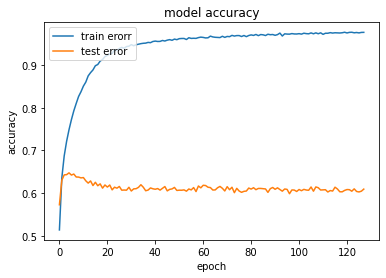

In [14]:
import matplotlib
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train erorr', 'test error'], loc='upper left')
plt.show()
